# Scheduling with optional tasks
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/optional_tasks.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

This notebook demonstrates how to solve scheduling problems with _optional_ tasks, which means that not all tasks are required to be scheduled.

Optional tasks appear in practice when products can be built following different processing plans. Each plan may require a different number of tasks, with each task having specific dependencies or constraints. For example, a product could be built using steps `A` followed by `B`, which require two different resources, or simply through step `C`, requiring one resource but with higher processing time.

Scheduling with optional tasks is known in the scheduling literature under different names:
- Alternative process plans [(Kis, 2003)](https://www.sciencedirect.com/science/article/pii/S0377221702008287)
- Distributed scheduling [(Naderi and Ruiz, 2010)](https://www.sciencedirect.com/science/article/pii/S0305054809001786)
- Scheduling with rejections [(Shabtay et al., 2013)](https://link.springer.com/article/10.1007/s10951-012-0303-z)
- Flexible project structures [(Kellenbrink and Helber, 2015)](http://refhub.elsevier.com/S0377-2217(24)00826-9/sb6)

We will show how to define scheduling problems with optional tasks and how to use selection constraints to solve complex versions of this problem.

## Setting optional tasks

Let's define a simple problem instance to demonstrate how to schedule with optional tasks. Tasks are required by default, but we can make them optional by passing the `optional=True` argument.

In [1]:
from pyjobshop import Model

In [2]:
model = Model()

machine = model.add_machine()

A = model.add_task(optional=True, name="A")
B = model.add_task(optional=True, name="B")
C = model.add_task(optional=True, name="C")

model.add_mode(A, machine, duration=1)
model.add_mode(B, machine, duration=1)
model.add_mode(C, machine, duration=3);

Next, we need to specify _how_ to select the tasks; otherwise, none of the tasks will be scheduled. PyJobShop supports a set of selection constraints (see the next section for an overview) to provide a simple way to declare which tasks need to be selected. This problem can be specified as follows:

In [3]:
model.add_select_exactly_one([A, C])  # Either A or C is scheduled
model.add_select_all_or_none([A, B]);  # A and B are both present or absent

In addition, if A is scheduled, then it must be scheduled before B:

In [4]:
model.add_end_before_start(A, B);

Now let's solve this problem instance and plot the solution:

In [5]:
result = model.solve(display=False)

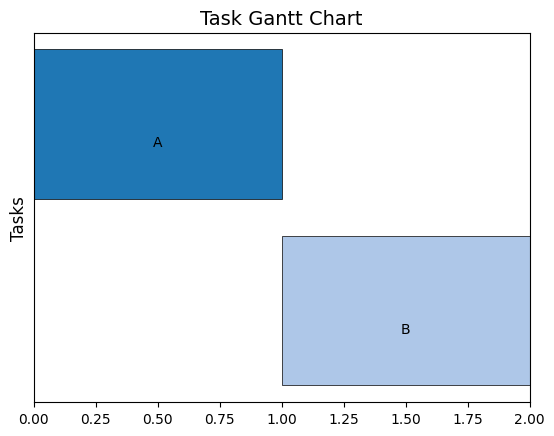

In [6]:
from pyjobshop.plot import plot_task_gantt

plot_task_gantt(result.best, model.data(), plot_labels=True)

Great, this solves the problem as expected! Tasks A and B are scheduled because this approach was shorter than scheduling C. 

Of course, this was just a simple toy problem. In realistic scenarios, task C might use a resource that is always available, whereas A and B could require a bottleneck machine. This would then favor scheduling task C.

## Selection constraints

PyJobShop provides three selection constraints that can be used to select optional tasks:

1. `SelectAllOrNone` - Either all tasks in the group are scheduled, or none are
2. `SelectAtLeastOne` - At least one task from the group must be scheduled  
3. `SelectExactlyOne` - Exactly one task from the group is scheduled

All selection constraints follow the same interface pattern, making them easy to use and combine:

```python
model.add_select_all_or_none(tasks, condition_task=None)
model.add_select_at_least_one(tasks, condition_task=None) 
model.add_select_exactly_one(tasks, condition_task=None)
```

The parameters are as follows:
- `tasks`: A list of tasks to apply the constraint to
- `condition_task` (optional): If specified, the constraint only applies when this specific task is scheduled

The `condition_task` parameter enables powerful "if-then" logic. This allows you to build complex processing plans by combining simple, well-defined selection rules. 

The following constraint enforces that if task X is scheduled, then exactly one of A, B, or C must be scheduled:

```python
model.add_select_exactly_one([A, B, C], condition_task=X);
```

Here's another example, which enforces that if task Y is scheduled, then all of D, E, F, and Y must be scheduled. Notice the inclusion of Y, which enforces scheduling _all_ tasks in the group:

```python
model.add_select_all_or_none([D, E, F, Y], condition_task=Y)
```

## Advanced if-then constraints

Let's put the if-then constraints into action. We'll use an example problem from [Van der Beek et al. (2025)](https://www.sciencedirect.com/science/article/pii/S0377221724008269). The diagram below illustrates two graphs: a selection graph, which dictates the selection of tasks and their subsequent tasks, and a precedence graph, which dictates the precedence between tasks if they are present.

![example](../assets/van-der-beek-selection.jpg)

A selection relationship between two tasks ($u$, $v$) means that if task $u$ is selected, then task $v$ must also be selected. A selection group, which has a condition task $u$ and a group of tasks $V$, requires that if $u$ is selected, then at least one task from $V$ must be selected.

Let's model this specific example, which defines how tasks `C-A`, `C-B`, `C-AB`, `I-A`, `I-AB`, and `I-B` should be selected based on the presence of others.

In [7]:
model = Model()

First, we have a `source` task marking the beginning of the project and a `target` task marking the end. These are typically required tasks. We also define all other tasks, which are all optional.

In [8]:
tasks = {"source": model.add_task(name="source")}

names = ["C-A", "C-B", "C-AB", "I-A", "I-AB", "I-B"]
tasks |= {name: model.add_task(optional=True, name=name) for name in names}

tasks["target"] = model.add_task(name="target")

For convenience, we assume there is a single resource, and that each optional task takes 1 time unit, whereas the source and target tasks require zero duration.

In [9]:
machine = model.add_machine()

model.add_mode(tasks["source"], machine, duration=0)
model.add_mode(tasks["target"], machine, duration=0)

for name in names:
    model.add_mode(tasks[name], machine, duration=1)

Let's put all the selection constraints in a list and then add them as selection constraints:

In [10]:
selection_groups = [
    ("source", ["C-A"]),
    ("source", ["C-B"]),
    ("C-A", ["I-A", "C-AB"]),
    ("C-B", ["C-AB", "I-B"]),
    ("C-AB", ["I-AB"]),
    ("I-A", ["target"]),
    ("I-B", ["target"]),
    ("I-AB", ["target"]),
]

for condition, group in selection_groups:
    model.add_select_at_least_one(
        [tasks[name] for name in group],
        condition_task=tasks[condition],
    )

We do the same for the precedence constraints. Note that precedence constraints (and other constraints) only apply if both tasks are selected.

In [11]:
precedence = [
    ("source", "C-A"),
    ("source", "C-B"),
    ("C-A", "I-A"),
    ("C-A", "C-AB"),
    ("C-B", "C-AB"),
    ("C-B", "I-B"),
    ("C-AB", "I-AB"),
    ("I-A", "I-B"),
    ("I-A", "target"),
    ("I-B", "target"),
    ("I-AB", "target"),
]

for pred, succ in precedence:
    model.add_end_before_start(tasks[pred], tasks[succ])

In [12]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 4.00
lower bound: 4.00
     status: Optimal
    runtime: 0.00 seconds


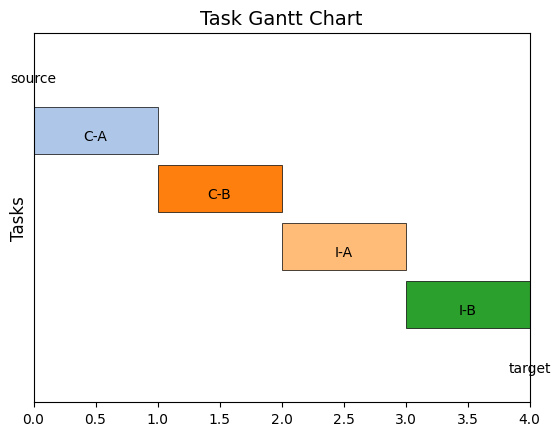

In [13]:
plot_task_gantt(result.best, model.data(), plot_labels=True)

Great, this result shows that a process plan from source to target is selected, while tasks `C-AB` and `I-AB` are skipped.

## Conclusion

This notebook showed how to model scheduling problems with optional tasks in PyJobShop. Key features include:

- **Optional tasks**: Set `optional=True` when creating tasks to let the solver decide whether to schedule them
- **Selection constraints**: Use `SelectAllOrNone`, `SelectAtLeastOne`, and `SelectExactlyOne` to control task selection
- **Conditional logic**: The `condition_task` parameter enables "if-then" relationships between tasks

These capabilities enable modeling of alternative process plans, flexible project structures, and complex scheduling scenarios where not all tasks need to be executed.